In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image, ImageEnhance
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [7]:
# Custom augmentation class
class HairAugmentation:
    def __init__(self, p=0.5):
        self.p = p
        
    def adjust_contrast(self, img):
        factor = random.uniform(0.5, 1.5)
        return ImageEnhance.Contrast(img).enhance(factor)
    
    def adjust_brightness(self, img):
        factor = random.uniform(0.5, 1.5)
        return ImageEnhance.Brightness(img).enhance(factor)
    
    def adjust_saturation(self, img):
        factor = random.uniform(0.5, 1.5)
        return ImageEnhance.Color(img).enhance(factor)
    
    def add_gaussian_noise(self, img):
        img_np = np.array(img)
        noise = np.random.normal(0, 25, img_np.shape)
        noisy_img = np.clip(img_np + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_img)
    
    def __call__(self, img):
        augmented = img
        
        if random.random() < self.p:
            augmented = self.adjust_contrast(augmented)
        if random.random() < self.p:
            augmented = self.adjust_brightness(augmented)
        if random.random() < self.p:
            augmented = self.adjust_saturation(augmented)
        if random.random() < self.p:
            augmented = self.add_gaussian_noise(augmented)
            
        return augmented

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=45),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=15
    ),
    HairAugmentation(p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.15))
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class HairDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, is_train=True):
        self.labels_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.is_train = is_train
        
        # Filter out rows where images don't exist
        valid_rows = []
        print(f"Checking for valid images in {img_dir}...")
        for idx, row in self.labels_frame.iterrows():
            img_path = os.path.join(self.img_dir, row['Image name'] + '.jpg')
            if os.path.exists(img_path):
                valid_rows.append(row)
        
        # Create new DataFrame with only valid rows
        self.labels_frame = pd.DataFrame(valid_rows)
        print(f"Found {len(self.labels_frame)} valid images out of {len(valid_rows)} total entries")
        
        if len(self.labels_frame) == 0:
            print(f"Warning: No valid images found in {img_dir}")
            return
        
        # Convert and normalize labels
        self.labels_frame['Curl Diameter'] = self.labels_frame['Curl Diameter'].astype(float)
        self.label_mean = self.labels_frame['Curl Diameter'].mean()
        self.label_std = self.labels_frame['Curl Diameter'].std()
        self.labels_frame['Curl Diameter'] = (self.labels_frame['Curl Diameter'] - self.label_mean) / self.label_std
    
    def __len__(self):
        return len(self.labels_frame)
    
    def __getitem__(self, idx):
        img_name = self.labels_frame.iloc[idx]['Image name']
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        
        image = Image.open(img_path).convert('RGB')
        label = self.labels_frame.iloc[idx]['Curl Diameter'].astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [60]:
class HairCNN(nn.Module):
    def __init__(self):
        super(HairCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x.squeeze()

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name='model'):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'r2': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []
        
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Validation Predictions:')
        print('-' * 60)
        print('Batch | True Diameter | Predicted | Difference')
        print('-' * 60)
        
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                predictions = model(images)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                # Denormalize predictions and labels
                denorm_labels = labels * train_dataset.dataset.label_std + train_dataset.dataset.label_mean
                denorm_preds = predictions * train_dataset.dataset.label_std + train_dataset.dataset.label_mean
                
                all_labels.extend(denorm_labels.cpu().numpy())
                all_preds.extend(denorm_preds.cpu().numpy())
                
                # Print batch predictions
                for i in range(len(labels)):
                    true_val = denorm_labels[i].item()
                    pred_val = denorm_preds[i].item()
                    diff = pred_val - true_val
                    print(f'{batch_idx:3d}-{i:2d} | {true_val:8.2f}    | {pred_val:8.2f} | {diff:+8.2f}')
        
        val_loss = val_loss / len(val_loader)
        history['val_loss'].append(val_loss)
        
        # Calculate statistics
        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        mae = np.mean(np.abs(all_labels - all_preds))
        r2 = 1 - np.sum((all_labels - all_preds) ** 2) / np.sum((all_labels - np.mean(all_labels)) ** 2)
        
        history['val_mae'].append(mae)
        history['r2'].append(r2)
        
        # print('\nOverall Statistics:')
        # print('-' * 60)
        # print(f'Training Loss (MSE): {epoch_loss:.4f}')
        # print(f'Validation Loss (MSE): {val_loss:.4f}')
        # print(f'Validation MAE: {mae:.4f}')
        # print(f'R-squared: {r2:.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'label_mean': train_dataset.dataset.label_mean,
                'label_std': train_dataset.dataset.label_std
            }, f'best_model_{model_name}.pth')
            print('New best model saved!')
    
    return history

# Prediction function
def predict_diameter(model, image_path, label_mean, label_std):
    model.eval()
    transform = val_transform
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(image)
        prediction = prediction * label_std + label_mean
        
    return prediction.item()

def visualize_predictions(model_path, val_loader, specific_images=None, num_samples=5):
    """
    Visualize model predictions using either validation loader or specific images.
    
    Args:
        model_path: The trained model checkpoint
        val_loader: Validation data loader
        specific_images: Optional list of specific image names to visualize
        num_samples: Number of samples to show if not using specific images
    """
    # Load the model weights and normalization parameters
    checkpoint = torch.load(model_path)
    model = HairCNN()
    model.load_state_dict(checkpoint['model_state_dict'])
    label_mean = checkpoint['label_mean']
    label_std = checkpoint['label_std']
    model.eval()
    
    if specific_images:
        # Filter dataset to get specific images
        dataset = val_loader.dataset
        indices = []
        for img_name in specific_images:
            # Find matching indices in dataset
            for i, (_, label_info) in enumerate(dataset.labels_frame.iterrows()):
                if img_name == label_info['Image name']:
                    indices.append(i)
                    break
        
        if not indices:
            print("No matching images found in dataset!")
            return
        
        # Create a subset of the dataset with only the specified images
        subset_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(dataset, indices),
            batch_size=len(indices),
            shuffle=False
        )
        images, labels = next(iter(subset_loader))
        
    else:
        # Get random batch from validation loader
        images, labels = next(iter(val_loader))
        images = images[:num_samples]
        labels = labels[:num_samples]
    
    images = images.to(device)
    labels = labels.to(device)
    num_images = len(images)
    
    # Make predictions
    with torch.no_grad():
        predictions = model(images)
    
    # Denormalize predictions and labels
    denorm_labels = labels * label_std + label_mean
    denorm_preds = predictions * label_std + label_mean
    
    # Create figure
    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4))
    if num_images == 1:
        axes = [axes]
    fig.suptitle('Model Predictions vs Ground Truth', fontsize=16)
    
    # Denormalize images for visualization
    denorm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    # Display each image and its predictions
    for i in range(num_images):
        # Denormalize and convert image for display
        img = denorm(images[i]).cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Get true and predicted values
        true_val = denorm_labels[i].item()
        pred_val = denorm_preds[i].item()
        error = pred_val - true_val
        
        # Display image and predictions
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f'True: {true_val:.2f}\nPred: {pred_val:.2f}\n'
            f'Error: {error:+.2f}',
            fontsize=10
        )
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nPrediction Statistics:")
    print("-" * 60)
    if specific_images:
        print("Results for specified images:")
        for i, img_name in enumerate(specific_images):
            print(f"{img_name}:")
            print(f"  True: {denorm_labels[i].item():.2f}")
            print(f"  Pred: {denorm_preds[i].item():.2f}")
            print(f"  Error: {(denorm_preds[i] - denorm_labels[i]).item():+.2f}")
            print("-" * 30)
    
    errors = (denorm_preds - denorm_labels).cpu().numpy()
    print("\nOverall Statistics:")
    print("-" * 40)
    print(f"Mean Absolute Error: {np.abs(errors).mean():.2f}")
    print(f"Mean Error: {errors.mean():.2f}")
    print(f"Error Std Dev: {errors.std():.2f}")
    print(f"Min Error: {errors.min():.2f}")
    print(f"Max Error: {errors.max():.2f}")


# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # MAE and R² plot
    ax2.plot(history['val_mae'], label='MAE')
    ax2.plot(history['r2'], label='R²')
    ax2.set_title('Validation Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Value')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create datasets
train_dataset = HairDataset(
    csv_file='/Users/nickrui/Desktop/HairType/images/hair_labels.csv',
    img_dir='/Users/nickrui/Desktop/HairType/images/raw_images',
    transform=train_transform,
    is_train=True
)

val_dataset = HairDataset(
    csv_file='/Users/nickrui/Desktop/HairType/images/hair_labels.csv',
    img_dir='/Users/nickrui/Desktop/HairType/images/raw_images',
    transform=val_transform,
    is_train=False
)

# Split datasets
total_size = len(train_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size])
_, val_dataset = torch.utils.data.random_split(val_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Initialize model, criterion, and optimizer
model = HairCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, model_name='raw')


# # Example of making a prediction
# image_path = '/Users/nickrui/Desktop/HairType/images/raw_images/example.jpg'  # Replace with actual image path
# predicted_diameter = predict_diameter(model, image_path, train_dataset.dataset.label_mean, train_dataset.dataset.label_std)
# print(f'Predicted curl diameter: {predicted_diameter:.2f}')

Using device: cpu
Checking for valid images in /Users/nickrui/Desktop/HairType/images/raw_images...
Found 42 valid images out of 42 total entries
Checking for valid images in /Users/nickrui/Desktop/HairType/images/raw_images...
Found 42 valid images out of 42 total entries


/Users/nickrui/Library/Python/3.12/lib/python/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/10] - Validation Predictions:
------------------------------------------------------------
Batch | True Diameter | Predicted | Difference
------------------------------------------------------------
  0- 0 |     3.00    |     0.37 |    -2.63
  0- 1 |     0.75    |     0.30 |    -0.45
  0- 2 |     0.70    |    -0.08 |    -0.78
  0- 3 |     2.00    |     0.44 |    -1.56
  0- 4 |     3.00    |    -0.23 |    -3.23
  0- 5 |     1.00    |     0.46 |    -0.54
  0- 6 |     0.20    |     0.44 |    +0.24
  0- 7 |     0.10    |    -0.17 |    -0.27
  0- 8 |     0.50    |    -0.22 |    -0.72
New best model saved!

Epoch [2/10] - Validation Predictions:
------------------------------------------------------------
Batch | True Diameter | Predicted | Difference
------------------------------------------------------------
  0- 0 |     3.00    |     1.45 |    -1.55
  0- 1 |     0.75    |     1.43 |    +0.68
  0- 2 |     0.70    |     1.48 |    +0.78
  0- 3 |     2.00    |     1.46 |    -0.54
 

{'train_loss': [0.6177765801548958,
  3.5060513019561768,
  0.7242137044668198,
  0.8383045196533203,
  0.5218908948008902,
  0.7549476772546768,
  1.2093444466590881,
  0.7548237890005112,
  0.7359153032302856,
  0.7670922577381134],
 'val_loss': [3.0153093338012695,
  1.528348445892334,
  1.5038559436798096,
  1.4533487558364868,
  1.4467368125915527,
  1.4490561485290527,
  1.4493228197097778,
  1.4508956670761108,
  1.446702480316162,
  1.4269238710403442],
 'val_mae': [np.float32(1.1588056),
  np.float32(1.0241792),
  np.float32(1.0173688),
  np.float32(0.9899288),
  np.float32(0.980437),
  np.float32(0.9798825),
  np.float32(0.97834545),
  np.float32(0.97562665),
  np.float32(0.9701612),
  np.float32(0.95413357)],
 'r2': [np.float32(-1.0951347),
  np.float32(-0.061946154),
  np.float32(-0.044927955),
  np.float32(-0.009833932),
  np.float32(-0.005239606),
  np.float32(-0.0068513155),
  np.float32(-0.0070365667),
  np.float32(-0.0081294775),
  np.float32(-0.0052158833),
  np.float

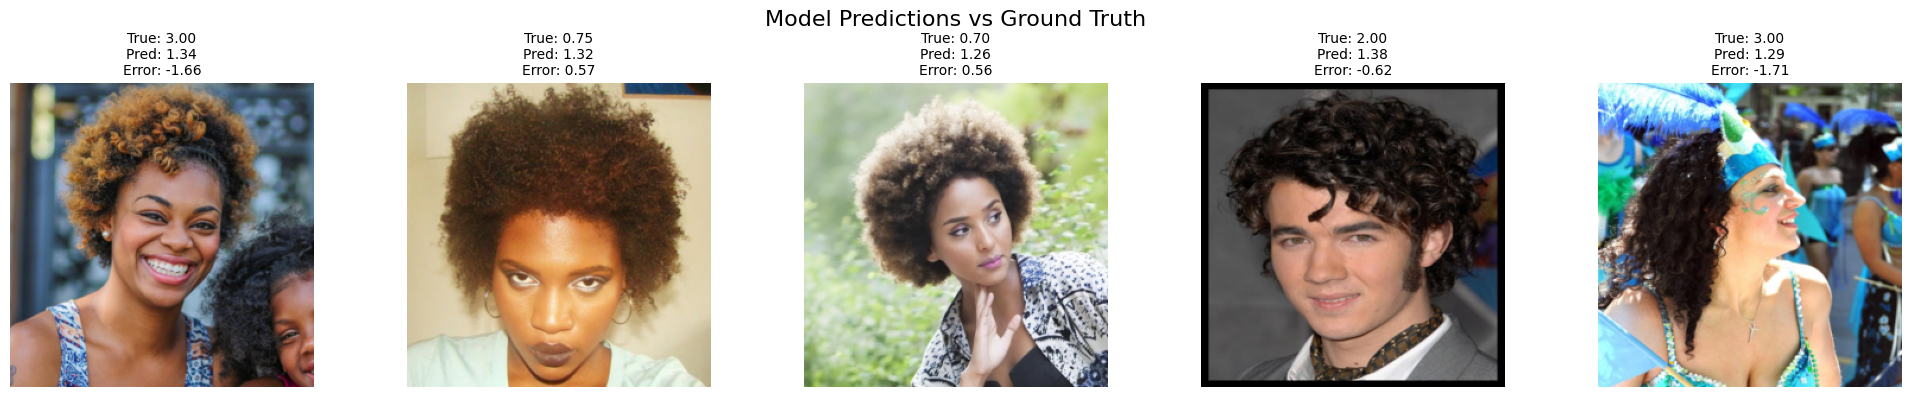


Prediction Statistics:
----------------------------------------
Mean Absolute Error: 1.02
Mean Error: -0.57
Error Std Dev: 1.01
Min Error: -1.71
Max Error: 0.57


In [20]:
visualize_predictions(model, val_loader, num_samples=5)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create datasets
train_dataset_patches = HairDataset(
    csv_file='/Users/nickrui/Desktop/HairType/images/hair_labels.csv',
    img_dir='/Users/nickrui/Desktop/HairType/images/enhanced_patches',
    transform=train_transform,
    is_train=True
)

val_dataset_patches = HairDataset(
    csv_file='/Users/nickrui/Desktop/HairType/images/hair_labels.csv',
    img_dir='/Users/nickrui/Desktop/HairType/images/enhanced_patches',
    transform=val_transform,
    is_train=False
)

# Split datasets
total_size = len(train_dataset_patches)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset_patches, _ = torch.utils.data.random_split(train_dataset_patches, [train_size, val_size])
_, val_dataset_patches = torch.utils.data.random_split(val_dataset_patches, [train_size, val_size])

# Create data loaders
train_loader_patches = DataLoader(train_dataset_patches, batch_size=32, shuffle=True, num_workers=0)
val_loader_patches = DataLoader(val_dataset_patches, batch_size=32, shuffle=False, num_workers=0)

# Initialize model, criterion, and optimizer
model = HairCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
train_model(model, train_loader_patches, val_loader_patches, criterion, optimizer, model_name='patches', num_epochs=50)

Using device: cpu
Checking for valid images in /Users/nickrui/Desktop/HairType/images/enhanced_patches...
Found 30 valid images out of 30 total entries
Checking for valid images in /Users/nickrui/Desktop/HairType/images/enhanced_patches...
Found 30 valid images out of 30 total entries

Epoch [1/50] - Validation Predictions:
------------------------------------------------------------
Batch | True Diameter | Predicted | Difference
------------------------------------------------------------
  0- 0 |     0.77    |    -4.59 |    -5.35
  0- 1 |     0.82    |    -5.84 |    -6.66
  0- 2 |     1.59    |    -3.75 |    -5.34
  0- 3 |     1.59    |    -6.04 |    -7.63
  0- 4 |     1.33    |    -6.21 |    -7.54
  0- 5 |     0.25    |    -5.94 |    -6.19
New best model saved!

Epoch [2/50] - Validation Predictions:
------------------------------------------------------------
Batch | True Diameter | Predicted | Difference
------------------------------------------------------------
  0- 0 |     0.7

{'train_loss': [0.9650095105171204,
  61.426666259765625,
  2.4965415000915527,
  1.7040835618972778,
  1.0816904306411743,
  0.9552972912788391,
  0.9281546473503113,
  0.9750439524650574,
  0.9800001978874207,
  0.9467377066612244,
  0.93365478515625,
  0.9047543406486511,
  0.9218525886535645,
  0.8745284080505371,
  0.8984534740447998,
  0.8951936364173889,
  0.8230757117271423,
  0.833214521408081,
  0.9077666401863098,
  0.8268387913703918,
  0.6639962792396545,
  0.9525651931762695,
  0.6473254561424255,
  0.8018394112586975,
  0.8336353898048401,
  0.7788564562797546,
  0.913080632686615,
  0.7463629245758057,
  0.6400576829910278,
  1.1330344676971436,
  0.7566556334495544,
  1.001455545425415,
  0.8773331642150879,
  0.8028154373168945,
  0.813018798828125,
  0.9484569430351257,
  0.8792779445648193,
  0.7978825569152832,
  0.773191511631012,
  0.8216032385826111,
  0.766369104385376,
  0.8066805005073547,
  0.6954879760742188,
  0.7798590064048767,
  0.9279550909996033,
  0.

/var/folders/7b/15bl2_8114g_4rr5xxxvdchr0000gn/T/ipykernel_1056/1505063411.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


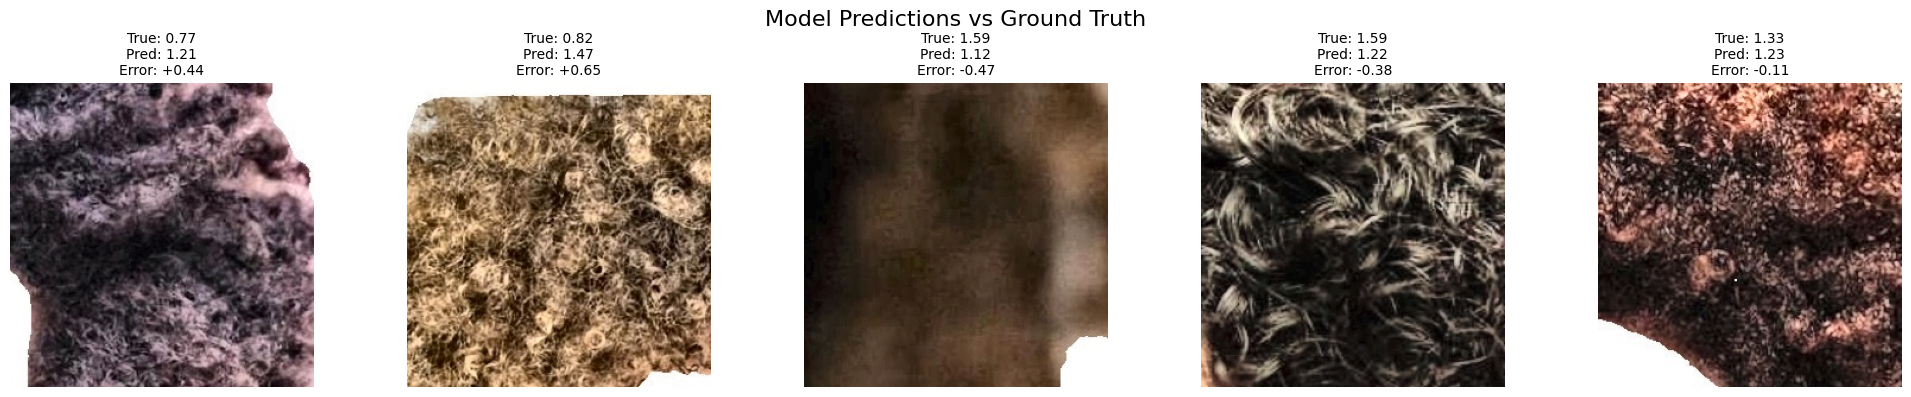


Prediction Statistics:
------------------------------------------------------------

Overall Statistics:
----------------------------------------
Mean Absolute Error: 0.41
Mean Error: 0.03
Error Std Dev: 0.45
Min Error: -0.47
Max Error: 0.65


In [62]:
model_path = '/Users/nickrui/Desktop/HairType/scripts/best_model_patches.pth'

# For random samples:
visualize_predictions(model_path, val_loader_patches, num_samples=5)

# # For specific images:
# specific_images = ['Frame00239-org', 'Frame00499-org']  # Use image names from your dataset
# visualize_predictions(model, val_loader, specific_images=specific_images)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create datasets
train_dataset_masked = HairDataset(
    csv_file='/Users/nickrui/Desktop/HairType/images/hair_labels.csv',
    img_dir='/Users/nickrui/Desktop/HairType/images/masked_images',
    transform=train_transform,
    is_train=True
)

val_dataset_masked = HairDataset(
    csv_file='/Users/nickrui/Desktop/HairType/images/hair_labels.csv',
    img_dir='/Users/nickrui/Desktop/HairType/images/masked_images',
    transform=val_transform,
    is_train=False
)

# Split datasets
total_size = len(train_dataset_masked)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset_masked, _ = torch.utils.data.random_split(train_dataset_masked, [train_size, val_size])
_, val_dataset_masked = torch.utils.data.random_split(val_dataset_masked, [train_size, val_size])

# Create data loaders
train_loader_masked = DataLoader(train_dataset_masked, batch_size=32, shuffle=True, num_workers=0)
val_loader_masked = DataLoader(val_dataset_masked, batch_size=32, shuffle=False, num_workers=0)

# Initialize model, criterion, and optimizer
model = HairCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
train_model(model, train_loader_masked, val_loader_masked, criterion, optimizer, model_name='masked')

Using device: cpu
Checking for valid images in /Users/nickrui/Desktop/HairType/images/masked_images...
Found 42 valid images out of 42 total entries
Checking for valid images in /Users/nickrui/Desktop/HairType/images/masked_images...
Found 42 valid images out of 42 total entries


/Users/nickrui/Library/Python/3.12/lib/python/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/10] - Validation Predictions:
------------------------------------------------------------
Batch | True Diameter | Predicted | Difference
------------------------------------------------------------
  0- 0 |     0.75    |     2.00 |    +1.25
  0- 1 |     2.00    |     1.99 |    -0.01
  0- 2 |     1.50    |     1.98 |    +0.48
  0- 3 |     3.00    |     1.87 |    -1.13
  0- 4 |     0.75    |     1.93 |    +1.18
  0- 5 |     0.70    |     1.89 |    +1.19
  0- 6 |     1.50    |     2.06 |    +0.56
  0- 7 |     1.50    |     2.07 |    +0.57
  0- 8 |     1.50    |     2.02 |    +0.52

Overall Statistics:
------------------------------------------------------------
Training Loss (MSE): 2.3962
Validation Loss (MSE): 0.9488
Validation MAE: 0.7655
R-squared: -0.5943
New best model saved!

Epoch [2/10] - Validation Predictions:
------------------------------------------------------------
Batch | True Diameter | Predicted | Difference
----------------------------------------------------

{'train_loss': [2.3961663842201233,
  0.9075691476464272,
  0.6877982690930367,
  0.6978052854537964,
  0.5843764543533325,
  0.6280648857355118,
  2.74673730134964,
  2.2120828926563263,
  0.5844058096408844,
  0.6962167918682098],
 'val_loss': [0.9487987160682678,
  1.5345286130905151,
  0.8537991642951965,
  0.6542136669158936,
  0.6690669655799866,
  0.7723445296287537,
  0.6720527410507202,
  0.6051604151725769,
  0.6105568408966064,
  0.6597634553909302],
 'val_mae': [np.float32(0.7654633),
  np.float32(0.7977464),
  np.float32(0.6265628),
  np.float32(0.5516047),
  np.float32(0.56949264),
  np.float32(0.63693976),
  np.float32(0.589134),
  np.float32(0.5276231),
  np.float32(0.5280882),
  np.float32(0.5674304)],
 'r2': [np.float32(-0.5942999),
  np.float32(-1.5785222),
  np.float32(-0.43466878),
  np.float32(-0.09929812),
  np.float32(-0.12425661),
  np.float32(-0.2977978),
  np.float32(-0.12927377),
  np.float32(-0.016872287),
  np.float32(-0.025940299),
  np.float32(-0.1086236

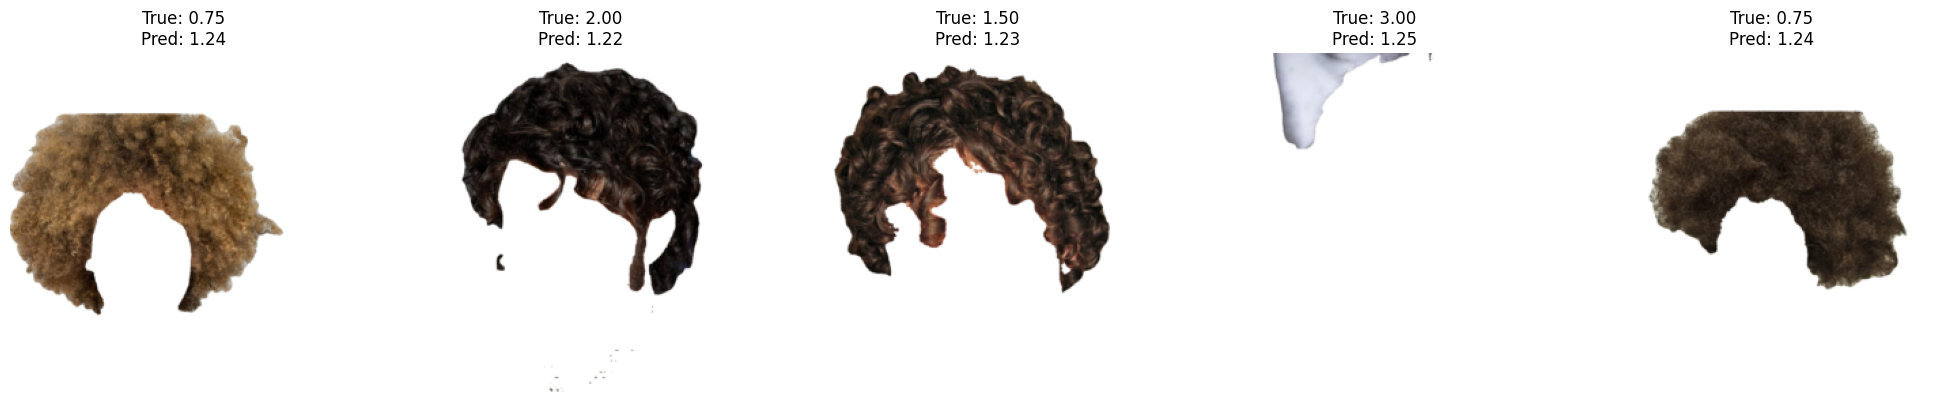

In [55]:
visualize_predictions(model, val_loader_masked, num_samples=5)